In [422]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [423]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import glob
import cv2

%matplotlib inline

In [424]:
potholes_positive_train = glob.glob("/content/drive/My Drive/Potholes_Dataset_1/Train/Potholes_Pos/*.jpg")

In [425]:
size = 90

In [426]:
train1 = [cv2.imread(img,0) for img in potholes_positive_train]
for i in range(0,len(train1)):
    train1[i] = cv2.resize(train1[i],(size,size))
temp1 = np.asarray(train1)


In [427]:
potholes_negative_train = glob.glob("/content/drive/My Drive/Potholes_Dataset_1/Train/Potholes_Neg/*.jpg")

In [428]:
train2 = [cv2.imread(img,0) for img in potholes_negative_train]
for i in range(0,len(train2)):
    train2[i] = cv2.resize(train2[i],(size,size))
temp2 = np.asarray(train2)

In [429]:
potholes_positive_test = glob.glob("/content/drive/My Drive/Potholes_Dataset_1/Test/Potholes_Pos/*.jpg")

In [430]:
test1 = [cv2.imread(img,0) for img in potholes_positive_test]
for i in range(0,len(test1)):
    test1[i] = cv2.resize(test1[i],(size,size))
temp3 = np.asarray(test1)

In [431]:
potholes_negative_test = glob.glob("/content/drive/My Drive/Potholes_Dataset_1/Test/Potholes_Neg/*.jpg")

In [432]:
test2 = [cv2.imread(img,0) for img in potholes_negative_test]
for i in range(0,len(test2)):
    test2[i] = cv2.resize(test2[i],(size,size))
temp4 = np.asarray(test2)

In [433]:
X_train = []
X_train.extend(temp1)
X_train.extend(temp2)
X_train = np.asarray(X_train)

In [434]:
X_test = []
X_test.extend(temp3)
X_test.extend(temp4)
X_test = np.asarray(X_test)

In [435]:
y_train1 = np.ones([temp1.shape[0]],dtype = int)
y_train2 = np.zeros([temp2.shape[0]],dtype = int)
y_test1 = np.ones([temp3.shape[0]],dtype = int)
y_test2 = np.zeros([temp4.shape[0]],dtype = int)

In [436]:
print(y_train1[0])
print(y_train2[0])
print(y_test1[0])
print(y_test2[0])

1
0
1
0


In [437]:
y_train = []
y_train.extend(y_train1)
y_train.extend(y_train2)
y_train = np.asarray(y_train)

In [438]:
y_test = []
y_test.extend(y_test1)
y_test.extend(y_test2)
y_test = np.asarray(y_test)

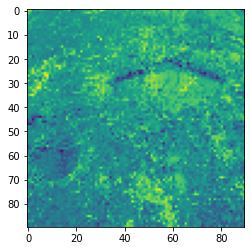

In [439]:
index = 66
plt.imshow(X_train[index])

In [440]:
y_train = y_train.reshape((1, y_train.shape[0]))
y_test = y_test.reshape((1, y_test.shape[0]))

In [441]:
m_train = X_train.shape[0]
m_test = X_test.shape[0]
print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))

Number of training examples: 379
Number of testing examples: 260


In [442]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(379, 90, 90)
(1, 379)
(260, 90, 90)
(1, 260)


In [443]:
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T

# Standardize the data
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

print ("X_train's shape: " + str(X_train.shape))
print ("X_test's shape: " + str(X_test.shape))

X_train's shape: (8100, 379)
X_test's shape: (8100, 260)


In [444]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

In [445]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ

In [446]:
def relu(Z):
    A = np.maximum(0,Z)
    assert (A.shape == Z.shape)
    cache = Z 
    return A, cache

In [456]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [457]:
layers_dims = [8100, 20, 7, 5, 1]

In [458]:
def initialize_parameters(layer_dims):
    parameters = {}
    L = len(layer_dims)    # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [459]:
def linear_forward(A, W, b):
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [460]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [461]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [462]:
def compute_cost(AL, Y): 
    m = Y.shape[1]

    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

In [463]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [464]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [465]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    # Initialize backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [466]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [467]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))
    
    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print ("predictions: " + str(p))
    print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [468]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    costs = []

    parameters = initialize_parameters(layers_dims)
    
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X,parameters)
        cost = compute_cost(AL,Y)

        grads = L_model_backward(AL,Y,caches)
        parameters = update_parameters(parameters,grads,learning_rate)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.662891
Cost after iteration 100: 0.484556
Cost after iteration 200: 0.453505
Cost after iteration 300: 0.404267
Cost after iteration 400: 0.375147
Cost after iteration 500: 0.345399
Cost after iteration 600: 0.315615
Cost after iteration 700: 0.282774
Cost after iteration 800: 0.295071
Cost after iteration 900: 0.279149
Cost after iteration 1000: 0.279271
Cost after iteration 1100: 0.277133
Cost after iteration 1200: 0.245459
Cost after iteration 1300: 0.438639
Cost after iteration 1400: 0.136021
Cost after iteration 1500: 0.096956
Cost after iteration 1600: 0.130348
Cost after iteration 1700: 0.096762
Cost after iteration 1800: 0.089768
Cost after iteration 1900: 0.052387
Cost after iteration 2000: 0.058573
Cost after iteration 2100: 0.027865
Cost after iteration 2200: 0.018939
Cost after iteration 2300: 0.012688
Cost after iteration 2400: 0.010149
Cost after iteration 2500: 0.008450
Cost after iteration 2600: 0.007194
Cost after iteration 2700: 0.006229
Cost

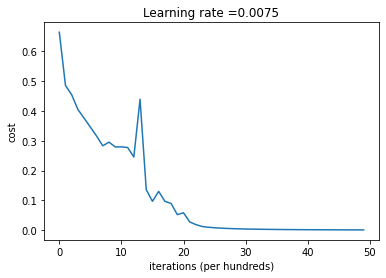

In [469]:
parameters = L_layer_model(X_train, y_train, layers_dims, num_iterations = 5000, print_cost = True)

In [470]:
predictions_train = predict(X_train, y_train, parameters)

predictions: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.

In [471]:
predictions_test = predict(X_test, y_test, parameters)

predictions: [[1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.
  1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
  1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1.
  1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.
  1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1.
  0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.]]
true labels: [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 